In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [15,8]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Thesis datasets/Weekly_Pharmaceutical_sales.csv')
df.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,1/5/2014,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
1,1/12/2014,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2,1/19/2014,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0
3,1/26/2014,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0
4,2/2/2014,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0


In [5]:
df.tail()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
297,9/15/2019,35.51,30.977,19.65,178.375,67.2,5.0,30.000000,30.50
298,9/22/2019,46.84,25.396,24.40,248.250,31.2,3.0,26.000000,21.00
299,9/29/2019,34.01,22.498,26.60,336.700,61.2,1.0,40.416667,23.10
300,10/6/2019,38.70,32.502,19.25,249.450,69.0,5.0,30.000000,12.13
301,10/13/2019,7.67,6.237,3.50,95.100,26.0,2.0,12.000000,1.00


In [6]:
df.shape

(302, 9)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   datum   302 non-null    object 
 1   M01AB   302 non-null    float64
 2   M01AE   302 non-null    float64
 3   N02BA   302 non-null    float64
 4   N02BE   302 non-null    float64
 5   N05B    302 non-null    float64
 6   N05C    302 non-null    float64
 7   R03     302 non-null    float64
 8   R06     302 non-null    float64
dtypes: float64(8), object(1)
memory usage: 21.4+ KB


In [8]:
time = pd.date_range(start='1/5/2014',periods=302,freq='W')
df['time_stamp'] = pd.DataFrame(time)
df.drop('datum',axis=1,inplace=True)
df = df.set_index('time_stamp')

In [9]:
df.head()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
time_stamp,,,,,,,,
2014-01-05,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
2014-01-12,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2014-01-19,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0
2014-01-26,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0
2014-02-02,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0


In [10]:
df.tail()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
time_stamp,,,,,,,,
2019-09-15,35.51,30.977,19.65,178.375,67.2,5.0,30.000000,30.50
2019-09-22,46.84,25.396,24.40,248.250,31.2,3.0,26.000000,21.00
2019-09-29,34.01,22.498,26.60,336.700,61.2,1.0,40.416667,23.10
2019-10-06,38.70,32.502,19.25,249.450,69.0,5.0,30.000000,12.13
2019-10-13,7.67,6.237,3.50,95.100,26.0,2.0,12.000000,1.00


In [11]:
df = df[['N02BE']]
df

,N02BE
time_stamp,
2014-01-05,185.950
2014-01-12,190.700
2014-01-19,218.400
2014-01-26,179.600
2014-02-02,159.880
...,...
2019-09-15,178.375
2019-09-22,248.250
2019-09-29,336.700


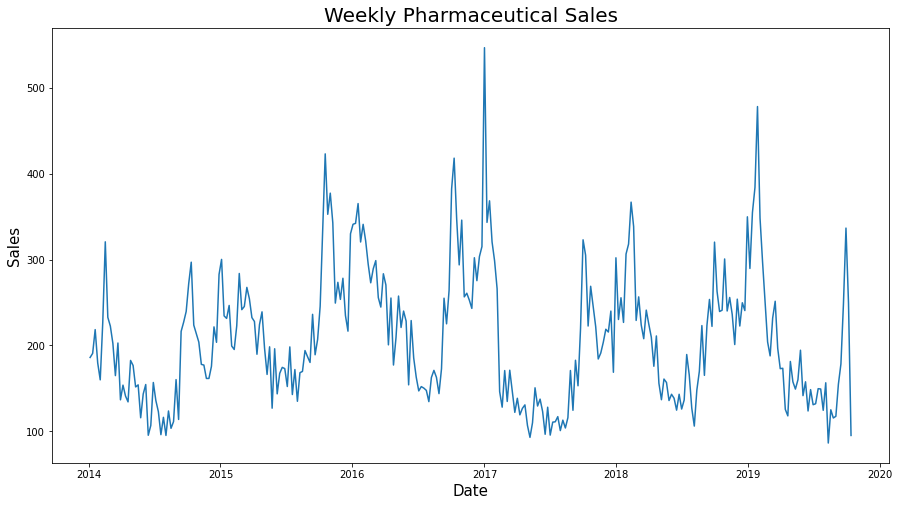

In [12]:
plt.plot(df)
plt.title('Weekly Pharmaceutical Sales',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Sales',fontsize=15)
plt.show()

In [13]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [238]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['N02BE'] = df['N02BE'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [239]:
#Split data set into testing dataset and train dataset
train_size = 270
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 1
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [125]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(269, 1)
(269,)
(31, 1)
(31,)


In [17]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 8.6 MB/s 


In [20]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [83]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value=256,
                                            step=8),
                                            activation= "relu"))
        if hp.Boolean("dropout"):
          model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mae',
        metrics=['mae'])
    return model

In [85]:
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=1,
    directory='project',
    project_name='pharma Sales_4')

In [86]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [24]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=30,
             validation_data=(testX, testY))

Trial 20 Complete [00h 00m 12s]
val_mae: 0.07389749586582184

Best val_mae So Far: 0.05780375748872757
Total elapsed time: 00h 04m 44s
INFO:tensorflow:Oracle triggered exit


In [25]:
tuner.results_summary()

Results summary
Results in project/pharma Sales_3
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 8
units_0: 168
dropout: True
learning_rate: 0.0006507656377981272
units_1: 160
units_2: 160
units_3: 184
units_4: 56
units_5: 88
units_6: 72
units_7: 48
units_8: 24
units_9: 128
Score: 0.05780375748872757
Trial summary
Hyperparameters:
num_layers: 9
units_0: 136
dropout: False
learning_rate: 0.005728265752083152
units_1: 168
units_2: 216
units_3: 104
units_4: 176
units_5: 136
units_6: 120
units_7: 40
units_8: 200
Score: 0.05794906988739967
Trial summary
Hyperparameters:
num_layers: 6
units_0: 88
dropout: True
learning_rate: 0.0002150028547593435
units_1: 120
units_2: 224
units_3: 168
units_4: 128
units_5: 160
units_6: 56
units_7: 248
units_8: 184
Score: 0.05813988670706749
Trial summary
Hyperparameters:
num_layers: 9
units_0: 208
dropout: True
learning_rate: 0.0007995176857691584
units_1: 16
units_2: 72
units_3: 24
units_4: 208
units_5: 208
units_6: 80
units_7: 200
units_

In [29]:
from tensorflow.keras import optimizers

In [242]:
model = Sequential()
model.add(Dense(96,activation='relu',input_dim = 1))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.000005507656377981272)
model.compile(optimizer = ad, loss = 'mae', metrics = ['mae'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 30, epochs = 300)

Epoch 1/300
9/9 [==============================] - 1s 34ms/step - loss: 0.3252 - mae: 0.3252 - val_loss: 0.2282 - val_mae: 0.2282
Epoch 2/300
9/9 [==============================] - 0s 10ms/step - loss: 0.3242 - mae: 0.3242 - val_loss: 0.2273 - val_mae: 0.2273
Epoch 3/300
9/9 [==============================] - 0s 7ms/step - loss: 0.3232 - mae: 0.3232 - val_loss: 0.2265 - val_mae: 0.2265
Epoch 4/300
9/9 [==============================] - 0s 6ms/step - loss: 0.3222 - mae: 0.3222 - val_loss: 0.2256 - val_mae: 0.2256
Epoch 5/300
9/9 [==============================] - 0s 6ms/step - loss: 0.3212 - mae: 0.3212 - val_loss: 0.2247 - val_mae: 0.2247
Epoch 6/300
9/9 [==============================] - 0s 6ms/step - loss: 0.3202 - mae: 0.3202 - val_loss: 0.2238 - val_mae: 0.2238
Epoch 7/300
9/9 [==============================] - 0s 6ms/step - loss: 0.3191 - mae: 0.3191 - val_loss: 0.2229 - val_mae: 0.2229
Epoch 8/300
9/9 [==============================] - 0s 7ms/step - loss: 0.3181 - mae: 0.3181 - v

In [243]:
def model_loss(history):
    plt.figure(figsize=(15,8))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [244]:
trainX_2 = scaler.inverse_transform(trainX)
trainY_2 = scaler.inverse_transform([trainY])
testX_2 = scaler.inverse_transform(testX)
testY_2 = scaler.inverse_transform([testY])
train_score_2 = model.evaluate(trainX_2, trainY_2.reshape(-1,),verbose=0)
test_score_2 = model.evaluate(testX_2, testY_2.reshape(-1,),verbose=0)

Train MAE: 40.299046403430786
Test MAE: 29.603520378868794


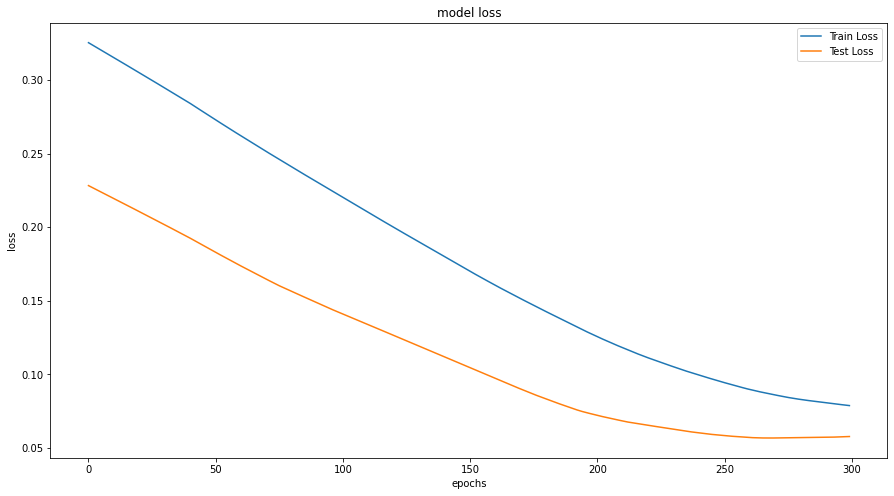

In [245]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print("Train MAE:",mae(trainY.reshape(-1,),train_predict.reshape(-1,)))
print("Test MAE:",mae(testY.reshape(-1,),test_predict.reshape(-1,)))
model_loss(model_history)

In [246]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(269,300)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

In [36]:
import seaborn as sns

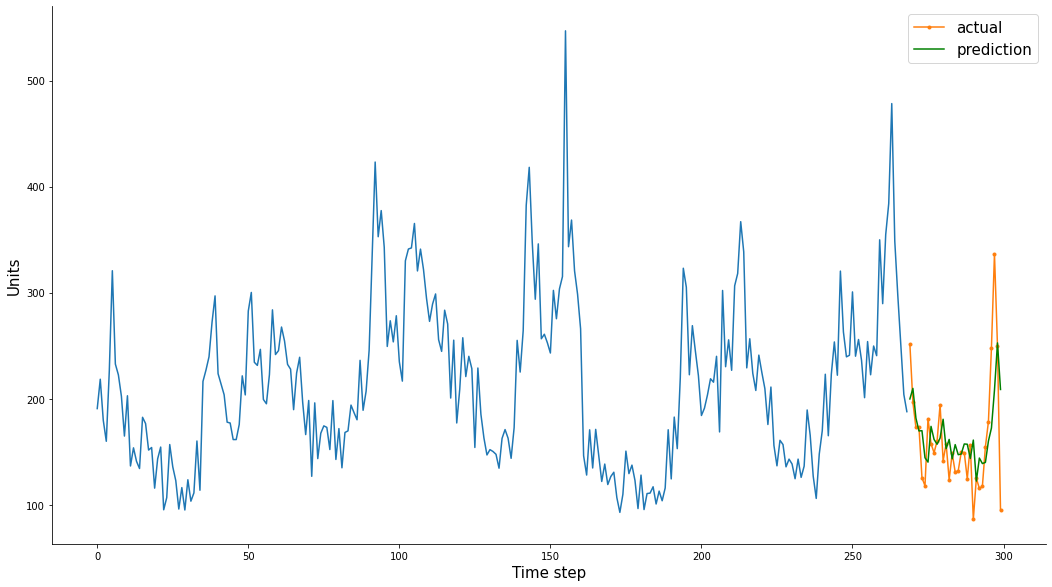

In [247]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)